In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import pandas as pd
import numpy as np
from numpy import *
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

import pickle
from keras import backend as K

from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model

In [2]:
max_text_len=512
max_summary_len=85

In [3]:
post_pre = pd.read_csv ('../Dataset/Indonesian News Dataset Preprocessed.csv', sep=';')

In [4]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

post_pre['text'] = post_pre['text'].astype(str)
post_pre['summary'] = post_pre['summary'].astype(str)

In [5]:
post_pre.head()

,text,summary
0,jakarta anggota komisi vii dpr ri rofik hanan...,sostok _START_ anggota komisi vii dpr ri rofik...
1,jakarta presiden joko widodo atau jokowi meme...,sostok _START_ presiden joko widodo telah meme...
2,wakil ketua mpr ri dr hidayat nur wahid ma at...,sostok _START_ wakil ketua mpr ri dr hidayat n...
3,jakarta tim kedokteran dan kesehatan dokkes p...,sostok _START_ tim kedokteran dan kesehatan do...
4,ketua mpr ri sekaligus ketua umum ikatan moto...,sostok _START_ ketua mpr ri bambang soesatyo t...


In [6]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [7]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [8]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 59.93512417638115
Total Coverage of rare words: 1.226265582590004


In [9]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 39525


In [10]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [11]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 58.711142993782886
Total Coverage of rare words: 2.310523215900181


In [12]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 17268


We will now remove "Summary" i.e Y (both train and val) which has only _START_ and _END_

In [13]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [14]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [15]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Size of vocabulary from the w2v model = 39525
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 512, 200)             7905000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 512, 300),           601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                

In [16]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [17]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [18]:
# Training with a progress bar
hist = model.fit([x_tr, y_tr[:,:-1]], 
                    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                    epochs=25,
                    batch_size=128,
                    validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]),
                    callbacks=[early_stopping])

# Save model, kalau mau load pake cell bawah
model.save('../Model/final_trained_model.h5')

Epoch 1/25
197/197 [==============================] - 821s 4s/step - loss: 5.9405 - val_loss: 5.3763
Epoch 2/25
197/197 [==============================] - 819s 4s/step - loss: 5.3593 - val_loss: 5.2912
Epoch 3/25
197/197 [==============================] - 816s 4s/step - loss: 5.3267 - val_loss: 5.2769
Epoch 4/25
197/197 [==============================] - 816s 4s/step - loss: 5.3034 - val_loss: 5.2383
Epoch 5/25
197/197 [==============================] - 816s 4s/step - loss: 5.2582 - val_loss: 5.1927
Epoch 6/25
197/197 [==============================] - 816s 4s/step - loss: 5.2108 - val_loss: 5.1490
Epoch 7/25
197/197 [==============================] - 813s 4s/step - loss: 5.1689 - val_loss: 5.1165
Epoch 8/25
197/197 [==============================] - 812s 4s/step - loss: 5.1307 - val_loss: 5.0777
Epoch 9/25
197/197 [==============================] - 812s 4s/step - loss: 5.0930 - val_loss: 5.0384
Epoch 10/25
197/197 [==============================] - 812s 4s/step - loss: 5.0517 - val_lo

In [19]:
# save:
f = open('../Model/seq2seq_trained_model_history.pckl', 'wb')
pickle.dump(hist.history, f)
f.close()

In [20]:
# retrieve:    
f = open('../Model/seq2seq_trained_model_history.pckl', 'rb')
history = pickle.load(f)
f.close()

In [21]:
# Load saved model

checkpoint_path = "../Model/final_trained_model.h5"

loaded_model = load_model(checkpoint_path)

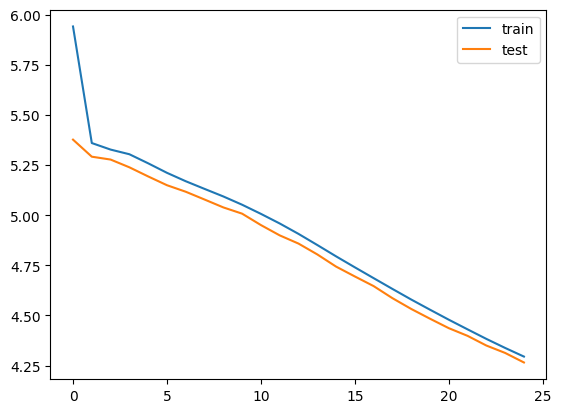

In [22]:
# Plot history
pyplot.plot(history['loss'], label='train')
pyplot.plot(history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Next, let’s build the dictionary to convert the index to word for target and source vocabulary:**

In [23]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [24]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

**We are defining a function below which is the implementation of the inference process**

In [25]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

**Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:**


In [26]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

**Run the model over the data to see the results**

In [31]:
# Select a random sample from the validation set
random_index = np.random.randint(0, len(x_val))
input_seq = x_val[2].reshape(1, -1)

# Generate predicted summary
predicted_summary = decode_sequence(input_seq)

# Convert sequences to text
original_text = seq2text(x_val[2])
original_summary = seq2summary(y_val[2])
predicted_summary = predicted_summary.replace('eostok', '').strip()

# Print the results
print("Original Text:", original_text)
print("Original Summary:", original_summary)
print("Predicted Summary:", predicted_summary)

1/1 [==============================] - 0s 11ms/step
Original Text: nilai tukar rupiah dibuka di posisi rp15 109 per dolar as di perdagangan pasar spot pada selasa 28 3 pagi mata uang garuda menguat 54 poin atau plus 36 persen dibandingkan penutupan di hari sebelumnya mata uang asia tercatat bervariasi yuan china turun 21 persen dolar singapura naik 18 persen baht thailand plus 27 persen dan ringgit malaysia menguat 71 persen kemudian yen jepang plus 56 persen won korea selatan naik 58 dan peso filipina turun 09 persen mata uang utama negara maju mayoritas menguat poundsterling inggris plus 19 persen euro eropa menguat 15 persen franc swiss naik 12 persen dan dolar kanada tumbuh 10 persen senior analis dcfx lukman leong memprediksi rupiah berpotensi menguat pada perdagangan pagi ini imbas sentimen risk on di pasar dengan meredanya kekhawatiran setelah berita first citizen yang akan membeli sebagian besar aset silicon valley bank svb rupiah diperkirakan akan menguat oleh sentimen risk on

In [28]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: singapura buruh migran indonesia bmi yang bekerja di singapura masita 33 divonis enam bulan penjara usai menggigit lengan bayi pelaku menggigit salah satu anak kembar yang seharusnya ia asuh dengan lembut dikutip dari channel news asia cna vonis itu jatuh pada hari ini selasa 4 4 2023 waktu setempat masita didakwa menganiaya bayi dengan sengaja sehingga menyebabkan rasa sakit yang tidak perlu masita sudah bekerja sejak 2021 tugas masita di keluarga tersebut ialah merawat bayi kembar serta mengurusi pekerjaan rumah tangga aksi gigit lengan itu berawal saat majikan masita meninggalkan rumah untuk menjemput anak sulungnya dari tk pada 26 mei 2022 sekitar pukul 17 00 waktu setempat sementara masita ditinggal di rumah bersama bayi kembarnya yang saat itu berusia 14 bulan masita mencoba menidurkan mereka tetapi menjadi frustrasi dengan salah satu bayi setelah sekitar setengah jam enggan tidur lalu masita merasa korban menunda tugasnya untuk memasak makan malam sekitar pukul 18 30 dia